# AutoMM for Semantic Segmentation - Quick Start

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/autogluon/autogluon/blob/stable/docs/tutorials/multimodal/image_segmentation/beginner_semantic_seg.ipynb)
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/autogluon/autogluon/blob/stable/docs/tutorials/multimodal/image_segmentation/beginner_semantic_seg.ipynb)


Semantic Segmentation is a computer vision task where the objective is to create a detailed pixel-wise segmentation map of an image, assigning each pixel to a specific class or object. This technology is crucial in various applications, such as in autonomous vehicles to identify vehicles, pedestrians, traffic signs, pavement, and other road features.

The Segment Anything Model (SAM) is a foundational model pretrained on a vast dataset with 1 billion masks and 11 million images. While SAM performs exceptionally well on generic scenes, it encounters challenges when applied to specialized domains like remote sensing, medical imagery, agriculture, and manufacturing. Fortunately, AutoMM comes to the rescue by facilitating the fine-tuning of SAM on domain-specific data.

In this easy-to-follow tutorial, we will guide you through the process of using AutoMM to fine-tune SAM. With just a single call to the `fit()` API, you can effortlessly train the model.


## Prepare Data
For demonstration purposes, we use the [Leaf Disease Segmentation](https://www.kaggle.com/datasets/sovitrath/leaf-disease-segmentation-with-trainvalid-split) from Kaggle. This dataset is a good example for automating disease detection in plants, especially for speeding up the plant pathology process. Segmenting specific regions on leaves or plants can be quite challenging, particularly when dealing with smaller diseased areas or various types of diseases.

To begin, download and prepare the dataset.

In [ ]:
!pip install autogluon.multimodal

  Using cached torch-2.3.1-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
Using cached torch-2.3.1-cp310-cp310-manylinux1_x86_64.whl (779.1 MB)


In [ ]:
!pip install autogluon
!pip install torch torchvision torchaudio transformers

In [ ]:
!pip uninstall torch torchaudio -y
!pip install torch torchvision torchaudio

Found existing installation: torch 2.3.1
Uninstalling torch-2.3.1:
  Successfully uninstalled torch-2.3.1
Found existing installation: torchaudio 2.3.1
Uninstalling torchaudio-2.3.1:
  Successfully uninstalled torchaudio-2.3.1
  Using cached torchaudio-2.4.1-cp310-cp310-manylinux1_x86_64.whl.metadata (6.4 kB)
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/usr/local/lib/python3.10/dist-packages/torch-2.3.1.dist-info/METADATA'



In [ ]:
!pip install autogluon --upgrade

In [ ]:
download_dir = './ag_automm_tutorial'
zip_file = 'https://automl-mm-bench.s3.amazonaws.com/semantic_segmentation/leaf_disease_segmentation.zip'
from autogluon.core.utils.loaders import load_zip
load_zip.unzip(zip_file, unzip_dir=download_dir)

100%|██████████| 53.3M/53.3M [00:08<00:00, 6.60MiB/s]


Next, load the CSV files, ensuring that relative paths are expanded to facilitate correct data loading during both training and testing.

In [ ]:
import pandas as pd
import os
dataset_path = os.path.join(download_dir, 'leaf_disease_segmentation')
train_data = pd.read_csv(f'{dataset_path}/train.csv', index_col=0)
val_data = pd.read_csv(f'{dataset_path}/val.csv', index_col=0)
test_data = pd.read_csv(f'{dataset_path}/test.csv', index_col=0)
image_col = 'image'
label_col = 'label'

In [ ]:
def path_expander(path, base_folder):
    path_l = path.split(';')
    return ';'.join([os.path.abspath(os.path.join(base_folder, path)) for path in path_l])

for per_col in [image_col, label_col]:
    train_data[per_col] = train_data[per_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
    val_data[per_col] = val_data[per_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
    test_data[per_col] = test_data[per_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))


print(train_data[image_col].iloc[0])
print(train_data[label_col].iloc[0])

/content/ag_automm_tutorial/leaf_disease_segmentation/train_images/00002.jpg
/content/ag_automm_tutorial/leaf_disease_segmentation/train_masks/00002.png


Each Pandas DataFrame contains two columns: one for image paths and the other for corresponding groundtruth masks. Let's take a closer look at the training data DataFrame.

In [ ]:
train_data.head()

,image,label
0,/content/ag_automm_tutorial/leaf_disease_segme...,/content/ag_automm_tutorial/leaf_disease_segme...
1,/content/ag_automm_tutorial/leaf_disease_segme...,/content/ag_automm_tutorial/leaf_disease_segme...
2,/content/ag_automm_tutorial/leaf_disease_segme...,/content/ag_automm_tutorial/leaf_disease_segme...
3,/content/ag_automm_tutorial/leaf_disease_segme...,/content/ag_automm_tutorial/leaf_disease_segme...
4,/content/ag_automm_tutorial/leaf_disease_segme...,/content/ag_automm_tutorial/leaf_disease_segme...


We can also visualize one image and its groundtruth mask.

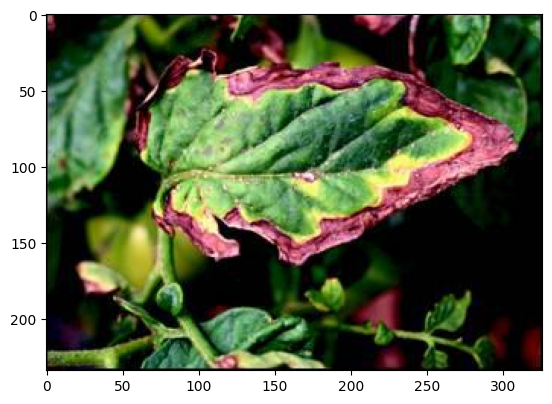

In [ ]:
from autogluon.multimodal.utils import SemanticSegmentationVisualizer
visualizer = SemanticSegmentationVisualizer()
visualizer.plot_image(test_data.iloc[1]['image'])

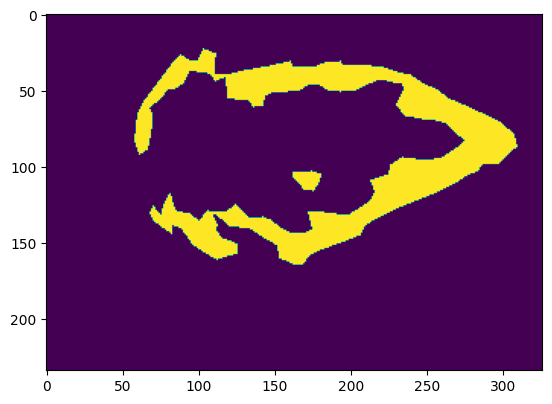

In [ ]:
visualizer.plot_image(test_data.iloc[1]['label'])

## Zero Shot Evaluation

Now, let's see how well the pretrained SAM can segment the images. For this demonstration, we'll use the base SAM model.

In [ ]:
from autogluon.multimodal import MultiModalPredictor
predictor_zero_shot = MultiModalPredictor(
    problem_type="semantic_segmentation",
    label=label_col,
     hyperparameters={
            "model.sam.checkpoint_name": "facebook/sam-vit-base",
        },
    num_classes=1, # forground-background segmentation
)

After initializing the predictor, you can perform inference directly.

In [ ]:
pred_zero_shot = predictor_zero_shot.predict({'image': [test_data.iloc[1]['image']]})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

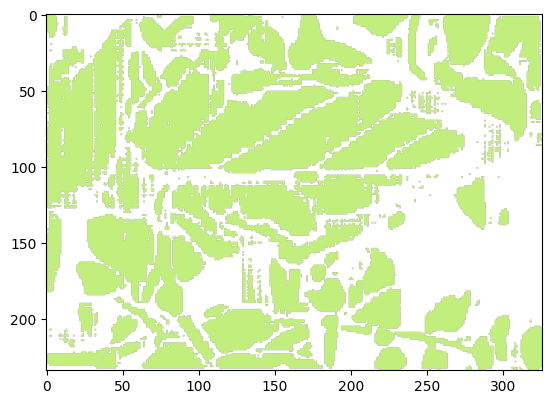

In [ ]:
visualizer.plot_mask(pred_zero_shot)

It's worth noting that SAM without prompts outputs a rough leaf mask instead of disease masks due to its lack of context about the domain task. While SAM can perform better with proper click prompts, it might not be an ideal end-to-end solution for some applications that require a standalone model for deployment.

You can also conduct a zero-shot evaluation on the test data.

In [ ]:
scores = predictor_zero_shot.evaluate(test_data, metrics=["iou"])
print(scores)

Predicting: |          | 0/? [00:00<?, ?it/s]

{'iou': 0.1402040272951126}


As expected, the test score of the zero-shot SAM is relatively low. Next, let's explore how to fine-tune SAM for enhanced performance.

## Finetune SAM

Initialize a new predictor and fit it with the training and validation data.

In [ ]:
from autogluon.multimodal import MultiModalPredictor
import uuid
save_path = f"./tmp/{uuid.uuid4().hex}-automm_semantic_seg"
predictor = MultiModalPredictor(
    problem_type="semantic_segmentation",
    label="label",
     hyperparameters={
            "model.sam.checkpoint_name": "facebook/sam-vit-base",
        },
    path=save_path,
)
predictor.fit(
    train_data=train_data,
    tuning_data=val_data,
    time_limit=180, # seconds
)

=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Pytorch Version:    2.3.1+cu121
CUDA Version:       12.1
Memory Avail:       8.56 GB / 12.67 GB (67.6%)
Disk Space Avail:   189.25 GB / 235.68 GB (80.3%)

AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /content/tmp/6ae74c9bdfdc486698642a42a1bea7b3-automm_semantic_seg
    ```

INFO: Seed set to 0
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
GPU Count:

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Training: |          | 0/? [00:00<?, ?it/s]

INFO: Time limit reached. Elapsed time is 0:03:00. Signaling Trainer to stop.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 87: 'val_iou' reached 0.56822 (best 0.56822), saving model to '/content/tmp/6ae74c9bdfdc486698642a42a1bea7b3-automm_semantic_seg/epoch=0-step=87.ckpt' as top 3
AutoMM has created your model. 🎉🎉🎉

To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/content/tmp/6ae74c9bdfdc486698642a42a1bea7b3-automm_semantic_seg")
    ```

If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub (https://github.com/autogluon/autogluon/issues).




Under the hood, we use [LoRA](https://arxiv.org/abs/2106.09685) for efficient fine-tuning. Note that, without hyperparameter customization, the huge SAM serves as the default model, which requires efficient fine-tuning in many cases.

After fine-tuning, evaluate SAM on the test data.

In [ ]:
scores = predictor.evaluate(test_data, metrics=["iou"])
print(scores)

Predicting: |          | 0/? [00:00<?, ?it/s]

{'iou': 0.5748448967933655}


Thanks to the fine-tuning process, the test score has significantly improved.

To visualize the impact, let's examine the predicted mask after fine-tuning.

In [ ]:
pred = predictor.predict({'image': [test_data.iloc[1]['image']]})

Predicting: |          | 0/? [00:00<?, ?it/s]

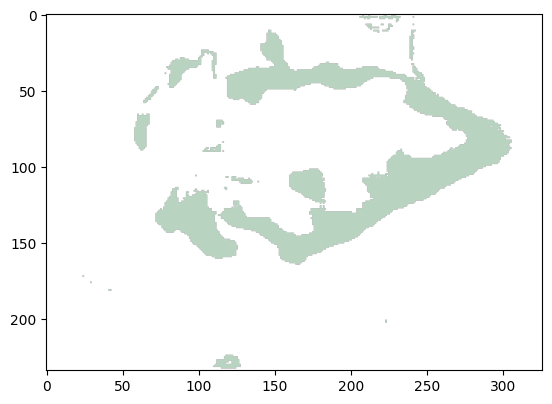

In [ ]:
visualizer.plot_mask(pred)

As evident from the results, the predicted mask is now much closer to the groundtruth. This demonstrates the effectiveness of using AutoMM to fine-tune SAM for domain-specific applications, enhancing its performance in tasks like leaf disease segmentation.

## Save and Load

The trained predictor is automatically saved at the end of `fit()`, and you can easily reload it.

```{warning}

`MultiModalPredictor.load()` uses `pickle` module implicitly, which is known to be insecure. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling. Never load data that could have come from an untrusted source, or that could have been tampered with. **Only load data you trust.**

```

In [ ]:
predictor.save(save_path)

In [ ]:
loaded_predictor = MultiModalPredictor.load(save_path)
scores = loaded_predictor.evaluate(test_data, metrics=["iou"])
print(scores)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Load pretrained checkpoint: /content/tmp/6ae74c9bdfdc486698642a42a1bea7b3-automm_semantic_seg/model.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

{'iou': 0.5748448967933655}


We can see the evaluation score is still the same as above, which means same model!

## Other Examples

You may go to [AutoMM Examples](https://github.com/autogluon/autogluon/tree/master/examples/automm) to explore other examples about AutoMM.

## Customization
To learn how to customize AutoMM, please refer to [Customize AutoMM](../advanced_topics/customization.ipynb).